# Regression quattro stagioni

_Linear regression implemented four different ways_

Linear regression is one of the simplest machine learning models out there. According to some it shouldn't even be classified as "machine learning" because it's too simple.
However you classify it, I believe its simplicity makes it a great stepping stone to more complex data and methods. In this post we will explore the foundation of linear regression and implement four different methods of training a regression model on linear data:

1. [Simple linear regression](#1.-Simple-linear-regression)
2. [Ordinary least squares regression](#2.-Ordinary-least-squares-regression)
3. [Gradient descent](#3.-Gradient-descent-optimization)
4. [MCMC parameter estimation with Metropolis-Hastings](#4.-Markov-Chain-Monte-Carlo-parameter-estimation)

We'll start of by describing the problem of linear regression and the toy data we'll use, followed by implementations of all four methods.

In [1]:
# Imports
%matplotlib notebook

import sys
import warnings
import numpy as np
from numpy import log, exp, sqrt, pi, e

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm  # Colormaps
import seaborn as sns

sns.set_style('darkgrid')
warnings.simplefilter(action='ignore', category=FutureWarning)
#

## Linear regression problem description

[Simple linear regression](https://en.wikipedia.org/wiki/Simple_linear_regression) will try to fit a linear relationship (straight line) between an independent variable $x$ (input) and an dependent variable $y$ (output).

For $n$ data samples the assumed linear relationship can be modelled as:

$$
y_i = \theta_0 + \theta_1 x_i + \epsilon_i  \quad (i = 1, \ldots, n)
$$

With:
- $x_i$ the independent (input) variable of sample $i$, with $x = \{x_i \ldots x_n \}$.
- $y_i$ the dependent (output) variable of sample $i$, with $y = \{y_i \ldots y_n \}$.
- $\epsilon_i \sim \mathcal{N}(0, \sigma^2)$ [Gaussian noise](https://en.wikipedia.org/wiki/Normal_distribution) affecting the output $y_i$.
- $\theta = \{\theta_0, \theta_1 \}$ the set of the parameters we want to optimize:
    - $\theta_0$ the intercept of the model (bias)
    - $\theta_1$ the coefficient of variable $x$ (slope)

We can use this discription to define our toy data sample:

<IPython.core.display.Javascript object>


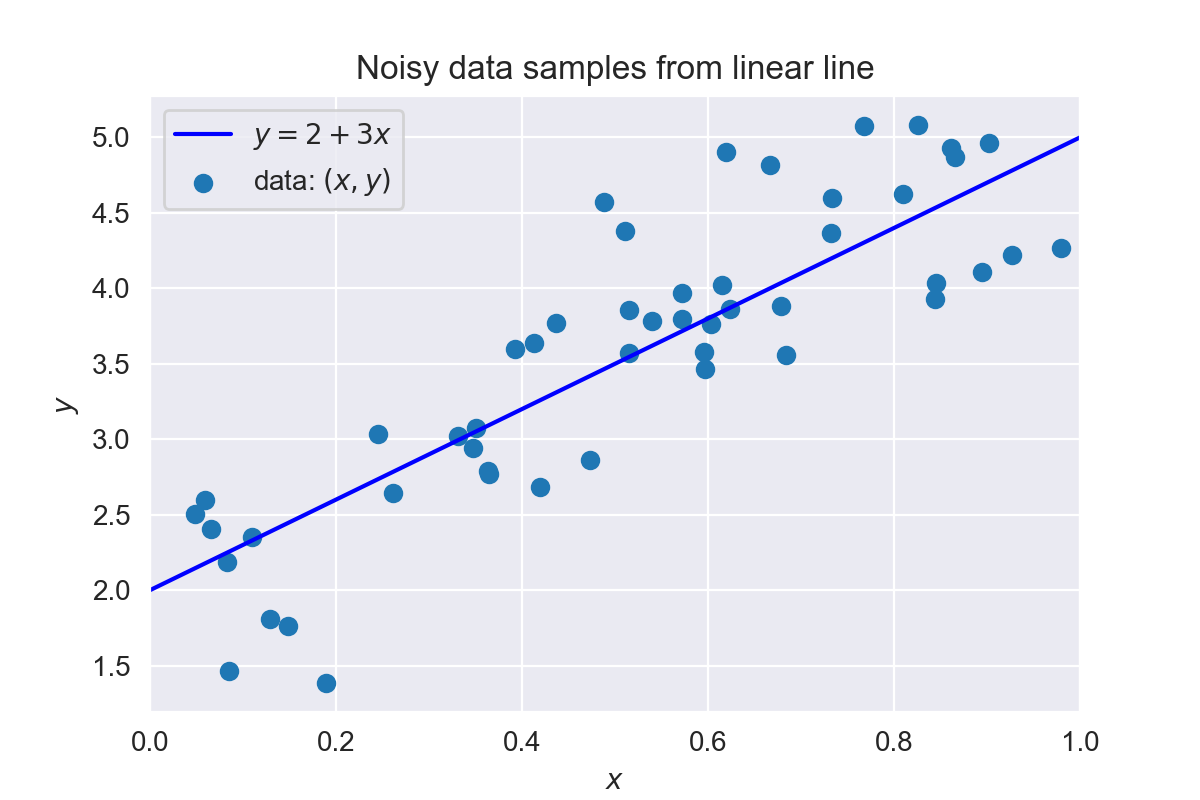

In [2]:
# Define the data
np.random.seed(4)
# Generate random data
n = 50 # Number of samples
# Underlying linear relation
m = 3  # slope
b = 2  # bias
# Noise
e_std = 0.5  # Standard deviation of the noise
err = e_std * np.random.randn(n)  # Noise
# Features and output
x = np.random.uniform(0, 1, n)  # Independent variable x
y = x * m + b + err  # Dependent variable
# Stack X with ones to be fitted by vectorized methods
#  such as OLS and gradient descent
X = np.vstack((np.ones_like(x), x)).T

# Show data
plt.figure(figsize=(6, 4))
plt.scatter(x, y, label='data: $(x,y)$')
plt.plot(
    [0, 1], [b, m+b], 'b-', 
    label=f'$y = {b:.0f} + {m:.0f} x$')
plt.xlim((0, 1))
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('Noisy data samples from linear line')
plt.legend()
plt.show()
#


### Probabilistic description

An alternative description is the [probabilistic](https://en.wikipedia.org/wiki/Bayesian_inference) description of the linear regression problem where we treat the dependent variable $y$ as randomly sampled from a normal distribution with a mean $\mu$ in function of the independent variable $x$ and random variables $\theta$.

$$
y_i \sim \mathcal{N}(\theta_0 + \theta_1 x_i, \sigma^2) \quad (i = 1, \ldots, n)
$$

Note that the mean $\mu = \theta_0 + \theta_1 x$. Given the definition of the [probability densitity](https://en.wikipedia.org/wiki/Probability_density_function) of the [normal distribution](https://en.wikipedia.org/wiki/Normal_distribution) we can write this as:

$$
p(y_i \mid \theta_0 + \theta_1 x_i, \sigma^2) = 
\frac{1}{\sqrt{2\pi\sigma^2}} \exp{ \left( -\frac{(y_i - (\theta_0 + \theta_1 x_i))^2}{2\sigma^2}\right)}
$$

Given the observed data $(x, y)$ and ignoring $\sigma^2$ we can then model the parameters $\theta$ as a density function which we can split up according to the [Bayes rule](https://en.wikipedia.org/wiki/Bayes%27_theorem):

$$
p(\theta \mid y, x) = \frac{p(y \mid x, \theta)p(\theta)}{p(y \mid x)}
$$

With:
- $P(\theta \mid y, x)$ the [posterior](https://en.wikipedia.org/wiki/Posterior_probability) density which is our belief of parameters $\theta$ after taking the observed data $(x, y)$ into account.
- $p(y \mid x, \theta)$ is the [likelihood](https://en.wikipedia.org/wiki/Likelihood_function) function which is the probability density of the normal distribution $y \sim \mathcal{N}(\theta_0 + \theta_1 x, \sigma^2)$ described above.
- $p(\theta)$ is the [prior](https://en.wikipedia.org/wiki/Prior_probability) density of $\theta$, which captures our belief about parameters $\theta$ before we observed any data. Note that we assume that $\theta$ is independent of $x$ and that $p(\theta \mid x) = p(\theta)$.
- $p(y \mid x)$ is the [marginal likelihood](https://en.wikipedia.org/wiki/Marginal_likelihood) of the data where $\theta$ has been [marginalized out](https://en.wikipedia.org/wiki/Marginal_distribution) according to $p(y \mid x) = \int_{\theta} p(y \mid x, \theta) p(\theta) d\theta$.

Note that the error $\epsilon$ is implicitly captured in this model by treating $y$ as sampled from a normal distribution parametrized by $x$ and $\theta$. In what follows we will also ignore fitting of the variance term $\sigma^2$ for practical purposes.

### Maximum a posteriori estimation (MAP)

We can find a [point estimate](https://en.wikipedia.org/wiki/Point_estimation) $\hat{\theta}$ to fit our parameters $\theta$ by finding the maximum of the posterior distribution $p(\theta \mid y, x)$:

$$
\hat{\theta} = \underset{\theta}{\text{argmax}}\;p(\theta \mid y, x) 
= \underset{\theta}{\text{argmax}}\; \frac{p(y \mid x, \theta)p(\theta)}{p(y \mid x)}
$$

This can be simplified this since the marginal likelihood $p(y \mid x)$ is independent of the parameters $\theta$, and thus won't have an effect on $\hat{\theta}$ corresponding to the maximum of the posterior:

$$
\hat{\theta} = \underset{\theta}{\text{argmax}}\;p(\theta \mid y, x) 
= \underset{\theta}{\text{argmax}}\; p(y \mid x, \theta)p(\theta)
$$

This is also known as [maximum a posteriori (MAP)](https://en.wikipedia.org/wiki/Maximum_a_posteriori_estimation) estimate. In practice most methods to fit the parameters $\theta$ will try to avoid computing the marginal likelihood $p(y \mid x)$, which can be computational expensive due to the integral.

### Maximum likelihood estimation (MLE)

Deviating from the Bayesian perspective, some of the models will ignore the prior $p(\theta)$ for simplicity. They will be treating $p(\theta)$ as an uninformative and [improper](https://en.wikipedia.org/wiki/Prior_probability#Improper_priors) prior:

$$
\hat{\theta} = \underset{\theta}{\text{argmax}}\;p(\theta \mid y, x) \approx \underset{\theta}{\text{argmax}}\; p(y \mid x, \theta)
$$

The resulting optimization is what is known as [maximum likelihood estimation (MLE)](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation), which will focus only on the [likelihood function](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation) $p(y \mid x, \theta)$ while ignoring the prior and marginal term completely.

In our regression example if we assume that all samples $y_i, x_i$ are taken independently from the [normal distribution](https://en.wikipedia.org/wiki/Normal_distribution) $y_i \sim \mathcal{N}(\theta_0 + \theta_1 x_i, \sigma^2)$ we can write the likelihood function based on the definition of the normal distribution's density function as was [mentioned before](#Bayesian-description):

$$
p(y \mid x, \theta_0, \theta_1) = \prod_{i=1}^{n} p(y_i \mid x_i, \theta_0, \theta_1) = 
\prod_{i=1}^{n} \frac{1}{\sqrt{2\pi\sigma^2}} \exp{ \left( -\frac{(y_i - (\theta_0 + \theta_1 x_i))^2}{2\sigma^2}\right)}
$$

In what follows we will describe 4 different algorithms that can be used to fit a linear regression model.

## 1. Simple linear regression

Given the density function above we can find the estimated parameters $\hat{\theta}_0$ and $\hat{\theta}_1$ corresponding to the maximum of the likelihood function $p(y \mid x, \theta_0, \theta_1)$.

Because the exponents of the density function are difficult to work with and can be numerically unstable we will transform the function with a [logarithmic function](https://en.wikipedia.org/wiki/Log_probability) which is [strictly increasing](https://en.wikipedia.org/wiki/Monotonic_function) and will thus not affect the maxima of the original likelihood function. We call the resulting function the [log-likelihood](https://en.wikipedia.org/wiki/Likelihood_function#Log-likelihood):

$$
\log(\prod_{i=1}^{n} p(y_i \mid x_i, \theta_0, \theta_1)) = n(1 - \log(\sqrt{2\pi\sigma^2}) - \frac{1}{2\sigma^2} \left[ \sum_{i=1}^{n} (y_i - (\theta_0 + \theta_1 x_i))^2 \right]
$$

We can then find the [maximum](https://en.wikipedia.org/wiki/Maxima_and_minima) for this function by finding where the [derivative](https://en.wikipedia.org/wiki/Derivative) of this function with respect to its parameters becomes 0. If we solve this for our parameters we find that:

$$\begin{align}
\hat{\theta}_1 &= \frac{\sum_{i=1}^{n}(x_i - \bar{x})(y_i - \bar{y})}{\sum_{i=1}^{n}(x_i - \bar{x})^2} \\
\hat{\theta}_0 &= \bar{y} - \hat{\theta}_1 \bar{x}
\end{align}$$

with $\bar{y}$ the mean of all dependent variables $y$ and $\bar{x}$ the mean of all independent variables $x$. We can easily implement this as:

In [3]:
# Simple linear regression
# Compute mean
x_mean = np.mean(x)
y_mean = np.mean(y)

# Compute parameters according to simple linear regression
theta_1 = (
    (x-x_mean) * (y-y_mean)).sum() / ((x-x_mean)**2).sum()
theta_0 = y_mean - theta_1 * x_mean

# Function representing fitted line
f = lambda x: theta_0 + theta_1 * x

<IPython.core.display.Javascript object>


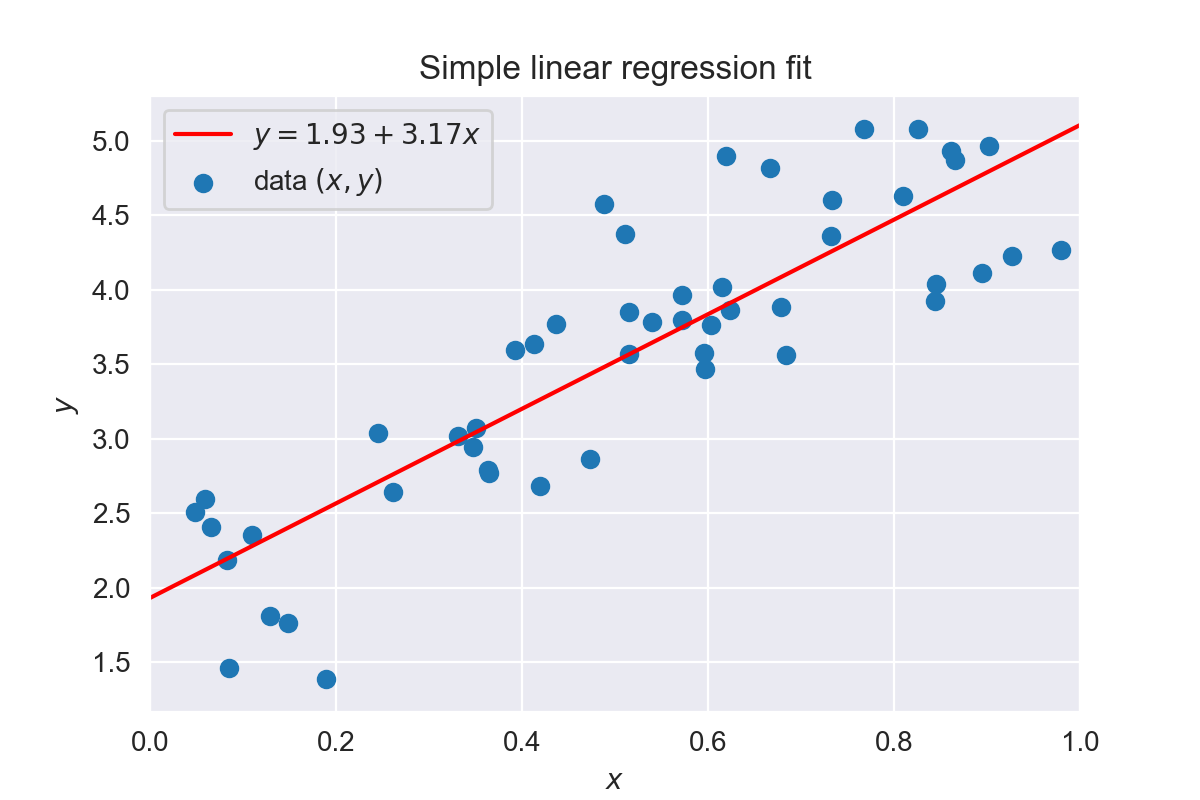

In [4]:
# Show simple linear regression fitted line
plt.figure(figsize=(6, 4))
plt.plot(
    [0, 1], [f(0), f(1)], 'r-', 
    label=f'$y = {theta_0:.2f} + {theta_1:.2f} x$')
plt.scatter(x, y, label='data $(x,y)$')
plt.legend()
plt.title('Simple linear regression fit')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.xlim((0, 1))
plt.show()
#

## 2. Ordinary least squares regression

Note that in the simple linear regression formulation above we end up maximising the log-likelihood which has the term $- \sum_{i=1}^{n} (y_i - (\theta_0 + \theta_1 x_i))^2$. This would be the same as minimizing the negative of this term. We can simplify this solution and make it more general by [vectorizing](https://en.wikipedia.org/wiki/Linear_algebra) our variables and data:

- $\Theta = [ \theta_0, \theta_1]$
- $X = [(1, x_1), \ldots , (1, x_n)]$
- $Y = [y_1, \ldots, y_n]$

Our optimization problem then becomes: 

$$
\hat{\Theta} = \underset{\Theta}{\text{argmin}}{\; \left\Vert Y-X\Theta \right\Vert^2}
$$

This is what is typically known as [ordinary least squares (OLS)](https://en.wikipedia.org/wiki/Ordinary_least_squares) since we are finding the solution with the least deviance in the square of the residuals (error), which is also known as [least squares](https://en.wikipedia.org/wiki/Least_squares). Note that in our example minimizing the least squares is the same as maximizing the likelihood (MLE).

We can solve this by setting the [Jacobian](https://en.wikipedia.org/wiki/Jacobian_matrix_and_determinant) (derivative) of $\left\Vert Y-X\Theta \right\Vert^2$ with respect to $\Theta$ to 0:

$$
\frac{\delta \left\Vert Y-X\Theta \right\Vert^2}{\delta \Theta} = -2X^{\top} (Y - X\Theta) = 0
$$

When we drop the $-2$ by multiplying this into the $0$ this gives us $X^{\top}X\hat{\Theta} = X^{\top}Y$, which leads us to the following solution:

$$
\hat{\Theta} = (X^{\top} X)^{-1} X^{\top} Y
$$

With $(X^{\top} X)^{-1} X^{\top}$ the [Moore-Penrose pseude-inverse](https://en.wikipedia.org/wiki/Moore%E2%80%93Penrose_inverse) of $X$.

The OLS method leads to more advanced regression methods such as [polynomial regression](https://en.wikipedia.org/wiki/Polynomial_regression). The OLS fitting example on our linear toy data is implemented below:

In [5]:
# Ordinary least squares
# Fit parameters with OLS
Theta = np.linalg.inv(X.T @ X) @ X.T @ y

# Function representing fitted line
f = lambda x: Theta[0] + Theta[1] * x

<IPython.core.display.Javascript object>


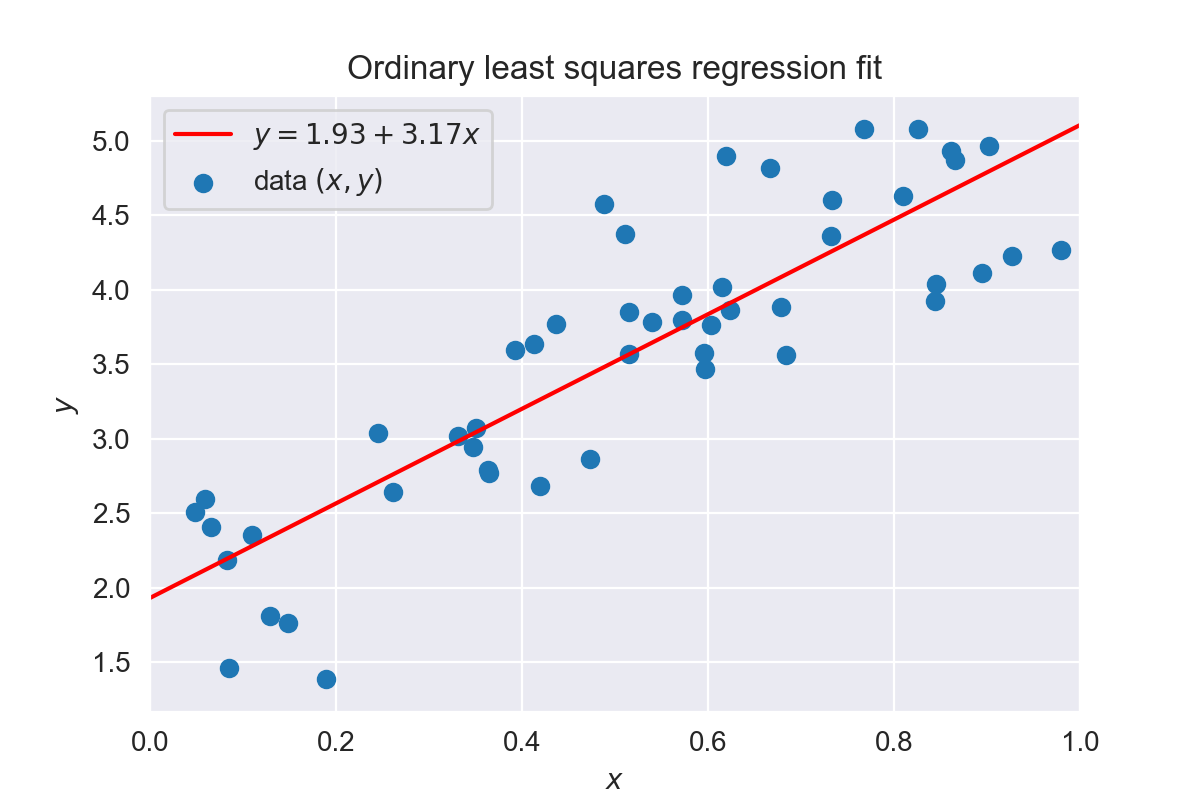

In [6]:
# Show OLS fitted line
plt.figure(figsize=(6, 4))
plt.plot(
    [0, 1], [f(0), f(1)], 'r-', 
    label=f'$y = {Theta[0]:.2f} + {Theta[1]:.2f} x$')
plt.scatter(x, y, label='data $(x,y)$')
plt.legend()
plt.title('Ordinary least squares regression fit')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.xlim((0, 1))
plt.show()
#

## 3. Gradient descent optimization

OLS assumes a unique solution to the least squares maximisation problem and will not work in more complex non-linear regression methods such as neural networks where our optimization surface is not [convex](https://en.wikipedia.org/wiki/Convex_function) anymore. In this case we can resort to [stochastic gradient descent](https://en.wikipedia.org/wiki/Stochastic_gradient_descent) to optimize the loss function.

Next we'll show how to optimize our parameters with regular [gradient descent](https://en.wikipedia.org/wiki/Gradient_descent) which can be made stochastic by breaking it down in random batches of size $m < n$.

We're optimizing the same [loss function](https://en.wikipedia.org/wiki/Loss_function) as in OLS, which means we're maximizing the log-likelihood:

$$
\hat{\Theta}  = \underset{\Theta}{\text{argmax}}\log \left( p(Y \mid X, \Theta) \right) = \underset{\Theta}{\text{argmin}}{\; \left\Vert Y-X\Theta \right\Vert^2}
$$

Now because we want to minimize this loss function we can just take small steps towards the [minimum](https://en.wikipedia.org/wiki/Maxima_and_minima) of this function, which lies in the oposite direction of the gradient. We saw that the [gradient](https://en.wikipedia.org/wiki/Gradient) (Jacobian, or derivative) of this loss function was:

$$
\frac{\delta \text{loss}}{\delta \Theta}  = \frac{\delta \left\Vert Y-X\Theta \right\Vert^2}{\delta \Theta} = -2X^T (Y - X\Theta)
$$

This means that if we start out with random parameters $\hat{\Theta}(0)$ we can update these parameters each iteration in the oposite direction of the gradient. Because our loss function is [convex](https://en.wikipedia.org/wiki/Convex_function) in this simple example we should end up at the minimum of our function after a certain amount of steps. One thing we have to make sure that the steps that we take are not to big so that we are not "stepping over" the minimum of our function. We introduce a learning rate parameter $\eta = 0.01$ to prevent this from happening. The parameter update for each iteration $k$ becomes:

$$
\hat{\Theta}(k+1) = \hat{\Theta}(k) - \eta \frac{\delta \text{loss}}{\delta \Theta(k)}
$$

The learning rate $\eta$ is an important parameter that needs to be carefully tuned. If it's too large the solution might never converge, if it's too small the convergence will take a lot of iterations. 

Note that in this case the gradient descent optimizer acts as a maximum likelihood estimator (MLE). Gradient descent and it's variants can be used to optimize complex neural network functions [[1, 2](#Further-readings)]. A simple implementation of gradient descent is provided below.

In [7]:
# Gradient descent update
def update(Theta, X, y, learning_rate):
    """Update the parameters with one iteration."""
    grad = - 2 * X.T @ (y - (X @ Theta))  # Compute gradient
    Theta -= grad * learning_rate  # Update paramters
    return Theta

In [8]:
# Implementation of gradient descent
# Random initial parameters
np.random.seed(13)
Theta = np.random.randn(2)
learning_rate = 0.01  # Learning rate
losses = []  # Will hold the loss (cost) per iteration
params = []  # Will hold the Theta params per iteration

# Run gradient descent for a number of steps
for i in range(50):
    Theta = update(Theta, X, y, learning_rate)
    # Store iterations for visualisation
    losses.append(np.mean((y-(X@Theta))**2))
    params.append(Theta.copy())

# Function representing fitted line
f = lambda x: Theta[0] + Theta[1] * x

<IPython.core.display.Javascript object>


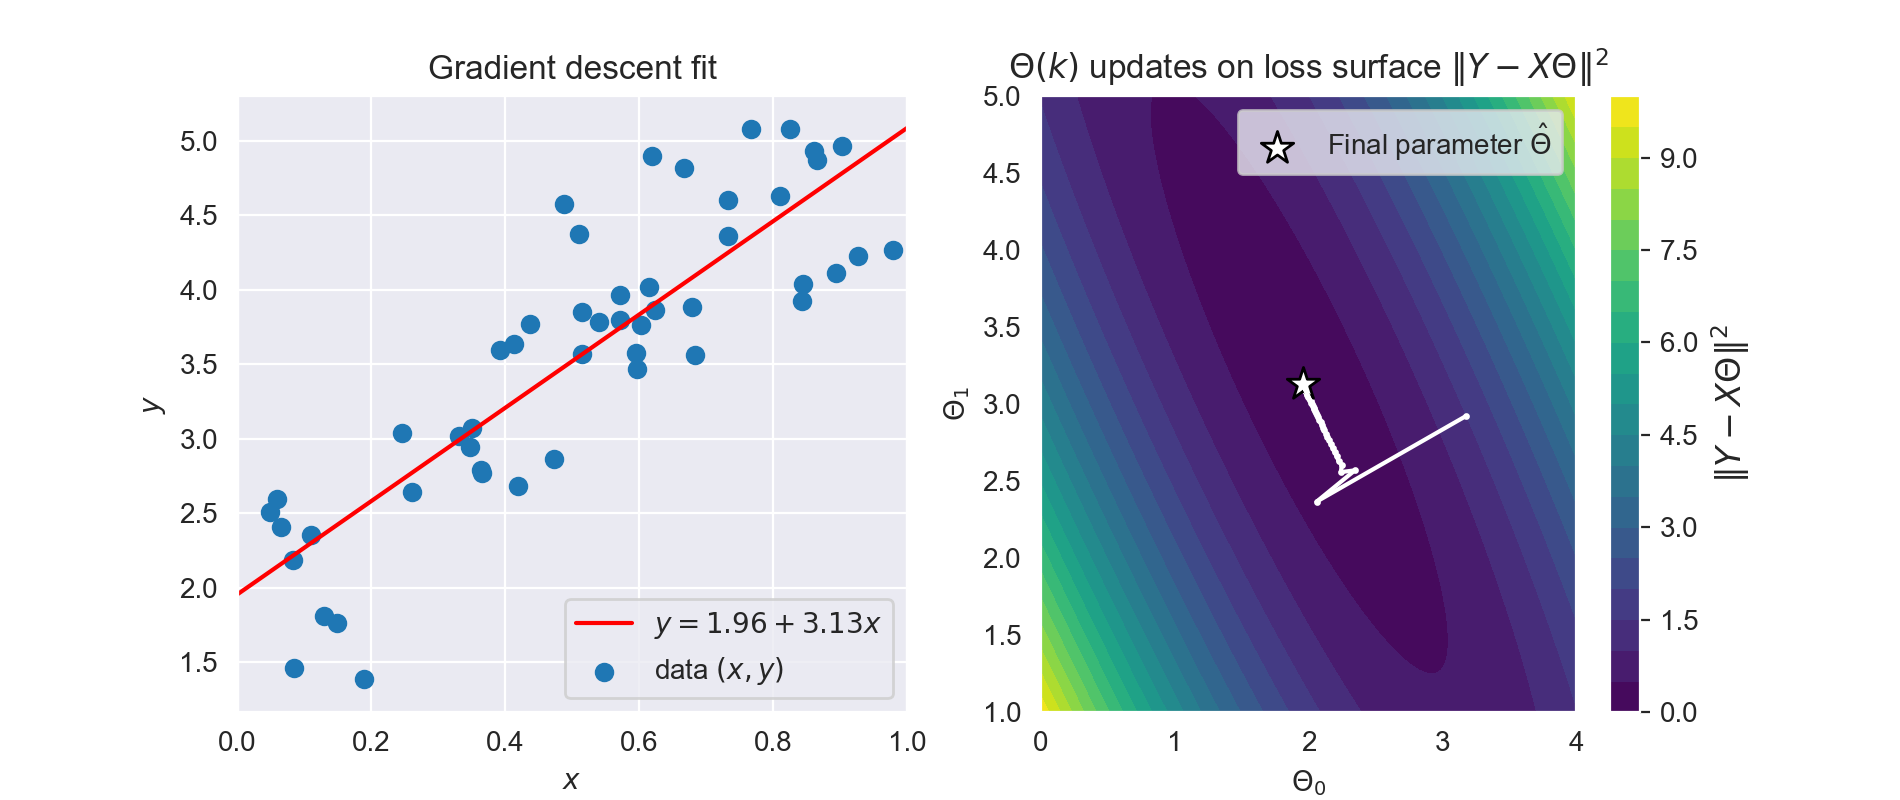

In [9]:
# Show fitted line
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9.5, 4))
ax1.plot(
    [0, 1], [f(0), f(1)], 'r-', 
    label=f'$y = {Theta[0]:.2f} + {Theta[1]:.2f} x$')
ax1.scatter(x, y, label='data $(x, y)$')
ax1.legend()
ax1.set_title('Gradient descent fit')
ax1.set_xlabel('$x$')
ax1.set_ylabel('$y$')
ax1.set_xlim((0, 1))
# Show loss surface
nb_of_ws = 100 # compute the loss nb_of_ws times in each dimension
wsa = np.linspace(0, 4, num=nb_of_ws) # theta_0
wsb = np.linspace(1, 5, num=nb_of_ws) # theta_1
ws_x, ws_y = np.meshgrid(wsa, wsb) # generate grid
loss_ws = np.zeros((nb_of_ws, nb_of_ws)) # initialize loss matrix
# Fill the loss matrix for each combination of weights
for i in range(nb_of_ws):
    for j in range(nb_of_ws):
        theta = np.asarray([ws_x[i,j], ws_y[i,j]])
        loss_ws[i,j] = np.mean((y - (X @ theta))**2)
# Plot the loss function surface
cont = ax2.contourf(ws_x, ws_y, loss_ws, 20, cmap=cm.viridis)
# Plot the parameter updates
theta_prev = None
for theta in params: 
    # Plot the param-loss values that represents the update
    ax2.scatter([theta[0]], [theta[1]], color='w', s=2)
    if theta_prev is not None:
        ax2.plot(
            [theta_prev[0], theta[0]], 
            [theta_prev[1], theta[1]], 'w-')
    theta_prev = theta
# Plot final parameter
ax2.scatter(
    [Theta[0]], [Theta[1]], label='Final parameter $\\hat{\\Theta}$',
    color='w', marker='*', s=150, edgecolors='k')
cbar = plt.colorbar(cont)
cbar.set_label('X+Y')
cbar.ax.set_ylabel(
    '$\\left\\Vert Y-X\\Theta \\right\\Vert^2$', fontsize=12)
ax2.set_title((
    '$\\Theta(k)$ updates on loss surface '
    '$\\left\\Vert Y-X\\Theta \\right\\Vert^2$'))
ax2.set_xlabel('$\\Theta_0$')
ax2.set_ylabel('$\\Theta_1$')
ax2.legend()
plt.show()
#

## 4. Markov Chain Monte Carlo parameter estimation

An alternative to optimizing the likelihood function is to [approximate](https://en.wikipedia.org/wiki/Approximate_Bayesian_computation) the full posterior by sampling based on [Markov Chain Monte Carlo (MCMC)](https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo) methods. One such sampling algorithm is the [Metropolis-Hastings algorithm](https://en.wikipedia.org/wiki/Metropolis–Hastings_algorithm) which allows us to sample from the posterior $p(\theta \mid y, x)$.

Remember that the posterior density of $\theta$ given the observed data $x, y$ is defined as:

$$
p(\theta \mid y, x) = \frac{p(y \mid x, \theta)p(\theta)}{p(y \mid x)}
$$


### Sampling with Metropolis-Hastings

The Metropolis-Hasting algorithm defines a way to create a [Markov chain](https://en.wikipedia.org/wiki/Markov_chain) which has as [stationary distribution](https://en.wikipedia.org/wiki/Stationary_distribution) the posterior $p(\theta \mid y, x)$ we're trying to approximate. What this means is that if we sample infinite number of samples from this markov chain the samples should be as if they were sampled from the posterior.

Given an initial guess for parameters $\theta(0)$, the Metropolis-Hastings algorithm works as follows
1. Propose a new parameter value $\theta_p$ by adding random noise to the the initial parameters: 

$$
\theta_{p}(k) = \theta(k) + \Delta \theta \quad \text{with}\; \Delta \theta \sim \mathcal{N}(0, \sigma^2)
$$

2. Find out how much more likely the new proposed parameter $\theta_{p}(k)$ is with respect to the previous parameter $\theta(k)$ by calculating the ratio: 

$$
\rho = \frac{p(\theta_p \mid y, x)}{p(\theta \mid y, x)} 
= \frac{\frac{p(y \mid x, \theta_p) p(\theta_p)}{p(y \mid x)}}{\frac{p(y \mid x, \theta)p(\theta)}{p(y \mid x)}} 
=\frac{p(y \mid x, \theta_p)p(\theta_p)}{p(y\mid x, \theta)p(\theta)}
$$

3. Then accept the proposal $\theta_{p}(k)$ as the new parameter $\theta(k+1)$ if the ratio $\rho \geq 1$, or if $\rho \lt 1$ accept $\theta_{p}(k)$ as new parameter with probability $\rho$. If not accepted keep $\theta(k+1)=\theta(k)$.

4. To keep sampling repeat from step 1.

For simplicity we will be ignoring the prior $p(\theta)$ below and treating it as an [improper prior](https://en.wikipedia.org/wiki/Prior_probability#Improper_priors) when calculuting the ratio (no intention to offend any Bayesian practitioners): 

$$
\rho = \frac{p(y \mid x, \theta_p)}{p(y \mid x, \theta)}
$$

If we want to add a specific prior this should be relatively simple and we shoud just multiply an extra term when calculating the ratio $\rho$. We will thus only use the ratio of the likelihood functions. We defined this likelhood function for our problem [earlier](#Bayesian-description) as:

$$
p(y \mid x, \theta_0, \theta_1) = \prod_{i=1}^{n} p(y_i \mid x_i, \theta_0, \theta_1) = \prod_{i=1}^{n} \frac{1}{\sqrt{2\pi\sigma^2}} \exp{ \left( -\frac{(y_i - (\theta_0 + \theta_1 x_i))^2}{2\sigma^2}\right)}
$$

To avoid [numerical underflow](https://en.wikipedia.org/wiki/Arithmetic_underflow) when probabilities are small we will be performing the computations in the [log](https://en.wikipedia.org/wiki/Log_probability) space where the multiplications will become additions.


###  Parameter estimation

After sampling we can find best point estimates of the parameter by [Bayesian estimation](https://en.wikipedia.org/wiki/Bayes_estimator) by taking the [expected value](https://en.wikipedia.org/wiki/Expected_value) ([mean](https://en.wikipedia.org/wiki/Arithmetic_mean)) of the sampled parameters. In practice we only compute the mean over the last samples because MCMC needs the first steps to converge towards the stationary distribution. A simple implementation on our toy data is provided below.

MCMC might be overkill for our simple toy problem, however, it can be used to approximate the posterior of complex distributions such as [multilevel models](https://docs.pymc.io/notebooks/multilevel_modeling.html). Powerfull software exists to sample from these complex methods more efficiently [[3](#Further-readings)].

In [10]:
def metropolis_hastings_step(y, x, theta_0, theta_1, sigma):
    """Single step of the Metropolis-Hastings algorithm."""
    # Run until new proposed sample has been accepted
    while True:
        theta_0_p = theta_0 + np.random.randn(1) * 0.1
        theta_1_p = theta_1 + np.random.randn(1) * 0.1
        sigma_p = sigma + np.random.randn(1) * 0.1
        log_ratio = (
            log_likelihood(y, x, theta_0_p, theta_1_p, sigma_p) - 
            log_likelihood(y, x, theta_0, theta_1, sigma))
        if log_ratio >= e:
            # Ratio >= 1: accept proposal
            return theta_0_p, theta_1_p, sigma_p
        elif log(np.random.uniform()) < log_ratio:
            # Ratio < 1: check with probability == ratio
            return theta_0_p, theta_1_p, sigma_p
        

def log_likelihood(y, x, theta_0, theta_1, sigma):
    """Log-likelihood function."""
    sigma_sq = sigma**2
    # Sum of squared errors
    sse = sum((y - (theta_0+theta_1*x)) ** 2)
    return - len(y) * log(sqrt(2*pi*sigma_sq)) \
        - (sse/(2*sigma_sq))

In [11]:
# Implementation of metropolis-Hasting MCMC
np.random.seed(1)

# Initial parameters
theta_0 = 1.
theta_1 = 1.
sigma = 1.

# Run Metropolis-Hastings MCMC
samples = []  # List of all samples
for _ in range(3000):
    # Generate new parameter proposals
    theta_0, theta_1, sigma = metropolis_hastings_step(
        y, x, theta_0, theta_1, sigma)
    samples.append((theta_0, theta_1, sigma))


th_0_samples, th_1_samples, sigma_samples = zip(*samples)
# Compute the expected value of the last samples
# The first 1000 samples are ignored because the MCMC has not 
#  yet converged
theta_0 = np.mean(th_0_samples[1000:])
theta_1 = np.mean(th_1_samples[1000:])

# Function representing fitted line
f = lambda x: theta_0 + theta_1 * x

<IPython.core.display.Javascript object>


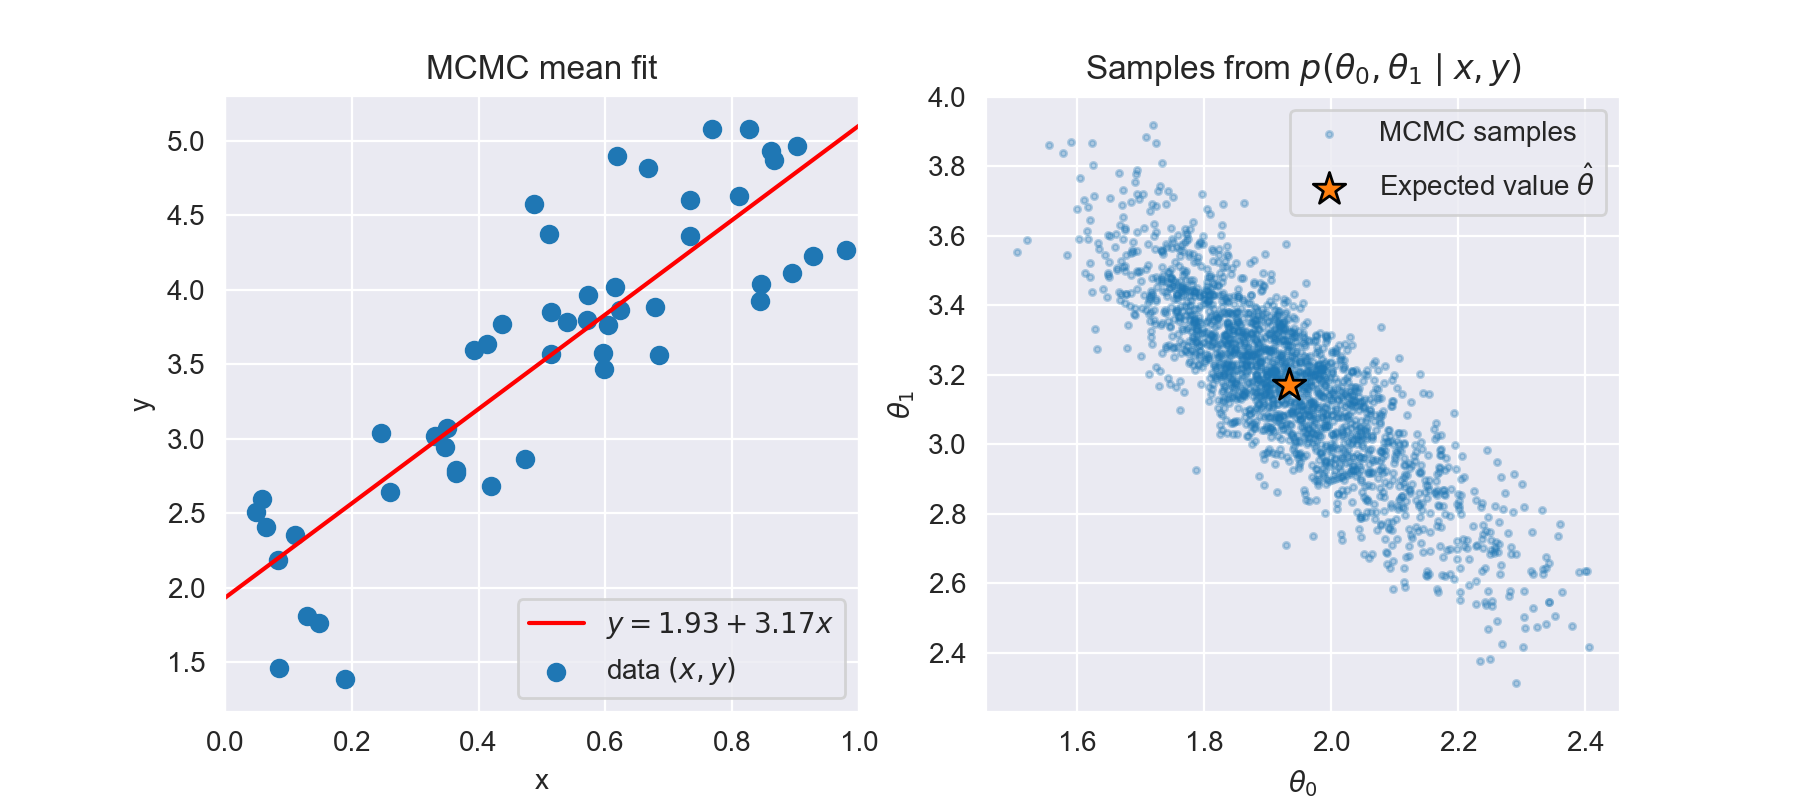

In [12]:
# Show fitted line
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9,4))
ax1.plot(
    [0, 1], [f(0), f(1)], 'r-', 
    label=f'$y = {theta_0:.2f} + {theta_1:.2f} x$')
ax1.scatter(x, y, label='data $(x,y)$')
ax1.legend()
ax1.set_title('MCMC mean fit')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_xlim((0, 1))
# Show distribution of theta_0 and theta_1
# sns.distplot(th_0_samples[1000:], ax=ax2, label='$\\theta_0$')
# sns.distplot(th_1_samples[1000:], ax=ax2, label='$\\theta_1$')
ax2.scatter(
    th_0_samples[1000:], th_1_samples[1000:], 
    alpha=0.3, s=5, label='MCMC samples')
ax2.scatter(
    [theta_0], [theta_1], label='Expected value $\\hat{\\theta}$',
    s=150, marker='*', edgecolors='k')
ax2.set_title('Samples from $p(\\theta_0, \\theta_1 \\mid x,y)$')
ax2.set_xlabel('$\\theta_0$')
ax2.set_ylabel('$\\theta_1$')
ax2.legend()
plt.show()
#

## Further readings

1. [Gradient descent optimization in neural networks](https://peterroelants.github.io/posts/neural-network-implementation-part01/).
2. Popular gradient descent optimization tools are [TensorFlow](https://www.tensorflow.org/) and [PyTorch](https://pytorch.org/).
3. Popular probabilistic programming tools supporting powerful sampling methods are [Stan](http://mc-stan.org/) and [PyMC3](https://docs.pymc.io/).

In [13]:
# Versions used
print('Python: {}.{}.{}'.format(*sys.version_info[:3]))
print('numpy: {}'.format(np.__version__))
print('matplotlib: {}'.format(matplotlib.__version__))
print('seaborn: {}'.format(sns.__version__))
#

Python: 3.7.0
numpy: 1.15.2
matplotlib: 3.0.0
seaborn: 0.9.0


This post at <a rel="canonical" href="https://peterroelants.github.io/posts/linear-regression-four-ways/">peterroelants.github.io</a> is generated from an IPython notebook file. [Link to the full IPython notebook file](https://github.com/peterroelants/peterroelants.github.io/blob/master/notebooks/misc/linear-regression-four-ways.ipynb)